C:\Users\mehdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5000 - loss: 0.5705 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 1.1921e-07 - val_accuracy: 0.5000 - val_loss: 1.1921e-07
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 

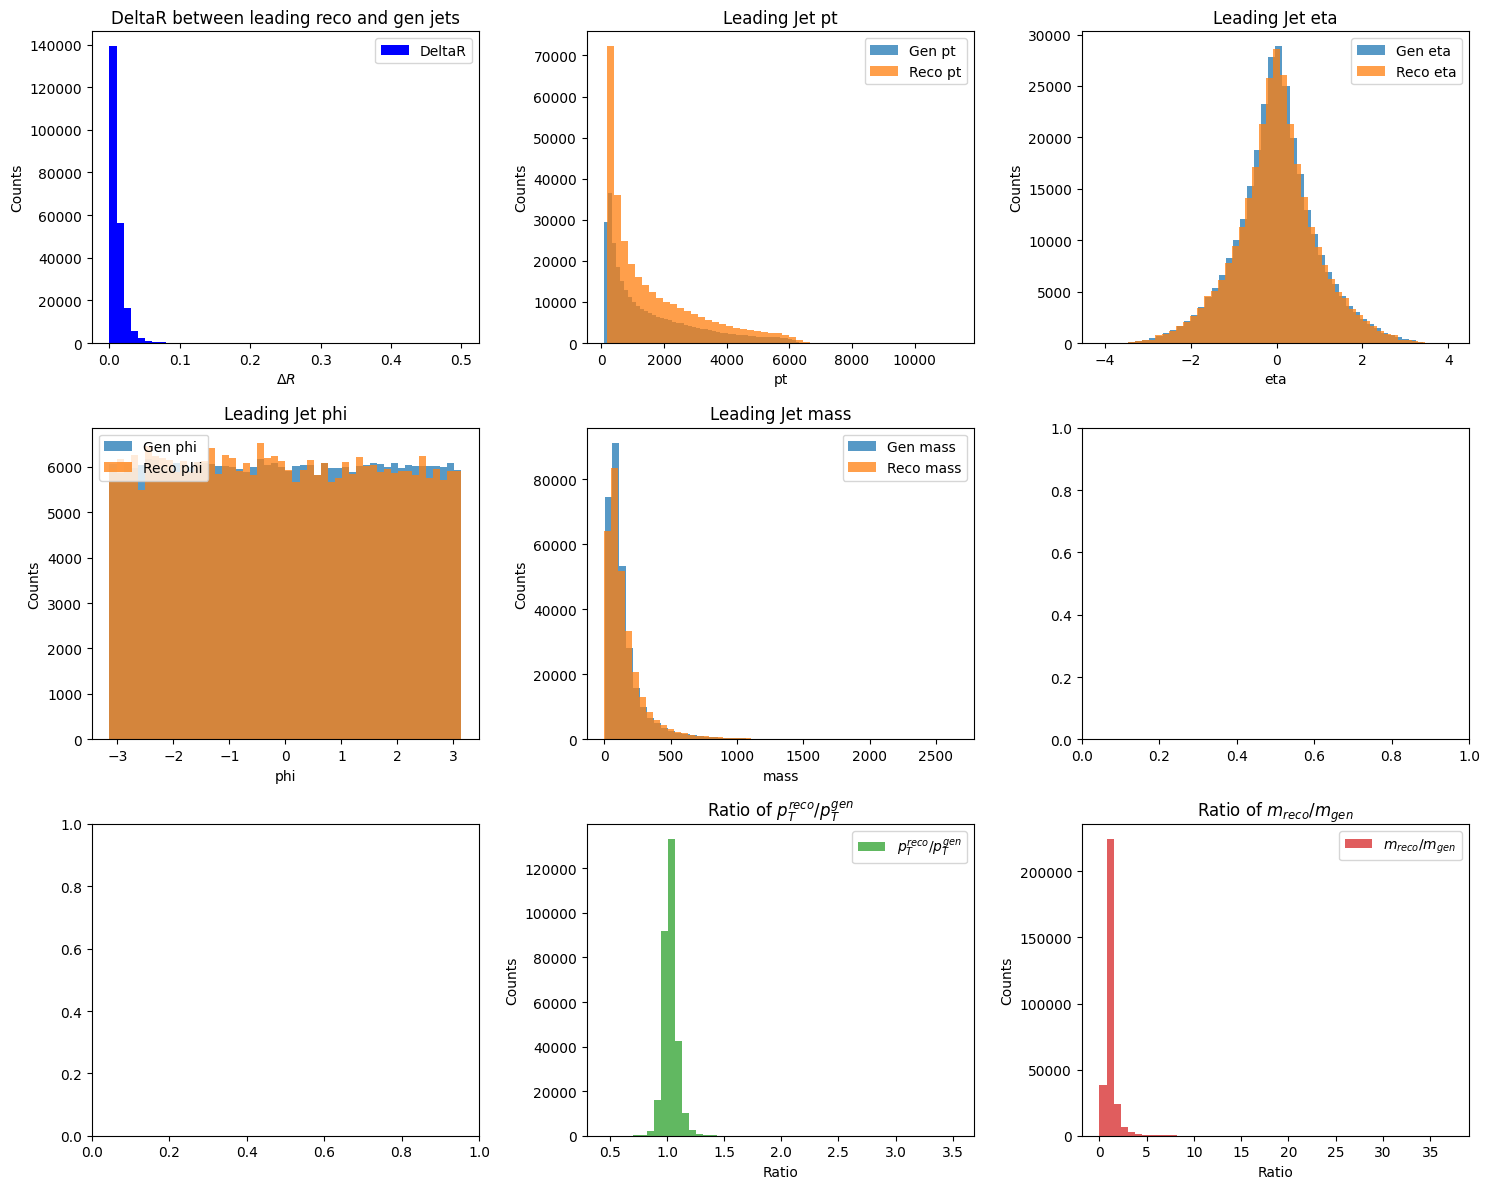

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Helper functions and OmniFold implementation

def reweight(events, model, batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1)  # event weights
    y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * (y_true * tf.keras.backend.log(y_pred) + (1 - y_true) * tf.keras.backend.log(1 - y_pred))
    return tf.keras.backend.mean(t_loss)

def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])
    return model

# Load data
qcd_mc = uproot.open('Data2.root')['Events']

# Extract reco and gen jet data
fields = ['pt', 'eta', 'phi', 'mass']
jet_reco = {f: qcd_mc[f'FatJet_{f}'].array()[:, :1] for f in fields}
jet_gen = {f: qcd_mc[f'GenJetAK8_{f}'].array()[:, :1] for f in fields}

# Mask to filter valid events
mask = (ak.num(jet_reco['pt'], axis=1) > 0) & (ak.num(jet_gen['pt'], axis=1) > 0)
for f in fields:
    jet_reco[f] = jet_reco[f][mask]
    jet_gen[f] = jet_gen[f][mask]

# Calculate DeltaR
delta_eta = ak.to_numpy(jet_reco['eta'] - jet_gen['eta']).flatten()
delta_phi = ak.to_numpy(np.mod(jet_reco['phi'] - jet_gen['phi'] + np.pi, 2 * np.pi) - np.pi).flatten()
delta_r = np.sqrt(delta_eta**2 + delta_phi**2)

# Prepare data for OmniFold reweighting
features = np.stack([
    ak.to_numpy(jet_gen['pt']).flatten(),
    ak.to_numpy(jet_gen['mass']).flatten()
], axis=-1)  # Now using both pt and mass for reweighting
weights = np.ones(len(features))

model = build_model(input_dim=features.shape[1])  # Updated input_dim

# OmniFold reweighting
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(
    features, np.zeros(len(features)), weights, test_size=0.2
)
Y_train = np.stack((Y_train, W_train), axis=1)
Y_test = np.stack((Y_test, W_test), axis=1)

model.fit(X_train, Y_train, epochs=20, batch_size=1000, validation_data=(X_test, Y_test), verbose=1)
weights = reweight(features, model)

# Calculate ratios using reweighted features
pt_ratio = ak.to_numpy(jet_reco['pt']).flatten() / features[:, 0]
mass_ratio = ak.to_numpy(jet_reco['mass']).flatten() / features[:, 1]

# Plotting
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

# Plot DeltaR
axs[0, 0].hist(delta_r, bins=50, range=(0, 0.5), color='blue', label='DeltaR')
axs[0, 0].set_title('DeltaR between leading reco and gen jets')
axs[0, 0].set_xlabel(r'$\Delta R$')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].legend()

# Plot for each property
for i, prop in enumerate(fields):
    gen_data = ak.to_numpy(ak.flatten(jet_gen[prop]))  # Convert to numpy if not already done
    reco_data = ak.to_numpy(ak.flatten(jet_reco[prop]))  # Convert to numpy if not already done
    axs[(i+1)//3, (i+1)%3].hist(gen_data, bins=50, alpha=0.75, label=f'Gen {prop}', color='C0')
    axs[(i+1)//3, (i+1)%3].hist(reco_data, bins=50, alpha=0.75, label=f'Reco {prop}', color='C1')
    axs[(i+1)//3, (i+1)%3].set_title(f'Leading Jet {prop}')
    axs[(i+1)//3, (i+1)%3].set_xlabel(f'{prop}')
    axs[(i+1)//3, (i+1)%3].set_ylabel('Counts')
    axs[(i+1)//3, (i+1)%3].legend()

# Plot pt and mass ratios
axs[2, 1].hist(pt_ratio, bins=50, alpha=0.75, label='$p_{T}^{reco}/p_{T}^{gen}$', color='C2')
axs[2, 1].set_title('Ratio of $p_{T}^{reco}/p_{T}^{gen}$')
axs[2, 1].set_xlabel('Ratio')
axs[2, 1].set_ylabel('Counts')
axs[2, 1].legend()

axs[2, 2].hist(mass_ratio, bins=50, alpha=0.75, label='$m_{reco}/m_{gen}$', color='C3')
axs[2, 2].set_title('Ratio of $m_{reco}/m_{gen}$')
axs[2, 2].set_xlabel('Ratio')
axs[2, 2].set_ylabel('Counts')
axs[2, 2].legend()

plt.tight_layout()
plt.show()
